#Multi-Class Waste Classification with 12 Categories Using Google Colab
This project aims to classify waste into 12 categories such as plastic, paper, glass, and metal. Key steps include:

* **Dataset:** Use a public waste dataset or collect labeled images for the 12
classes.
* **Preprocessing:** Resize all images (e.g., 224x224) and normalize pixel values.
* **Model:** Implement a CNN, or leveraging transfer learning with MobileNet or ResNet for efficiency.
* **Training:** Define batch size (e.g., 32) and epochs (50+); use categorical crossentropy loss.
* **Evaluation:** Assess performance with metrics like accuracy and a confusion matrix.
* **Deployment:** Train in Colab using its free GPU, then deploy for real-world applications like waste sorting.

## Importing available dataset and split it into train, test, and validation

In [1]:
!pip install kaggle

In [3]:
# Upload kaggle API
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aanalma03","key":"3e2789d959c8fb1ccd5160322686c759"}'}

In [4]:
# move API Key to proper directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# download kaggle datasets
!kaggle datasets download mostafaabla/garbage-classification

Dataset URL: https://www.kaggle.com/datasets/mostafaabla/garbage-classification
License(s): ODbL-1.0
 99% 237M/239M [00:11<00:00, 22.9MB/s]
100% 239M/239M [00:11<00:00, 20.9MB/s]


In [6]:
# unzip file
!unzip garbage-classification.zip -d ./garbage-dataset

Streaming output truncated to the last 5000 lines.
  inflating: ./garbage-dataset/garbage_classification/paper/paper381.jpg  
  inflating: ./garbage-dataset/garbage_classification/paper/paper382.jpg  
  inflating: ./garbage-dataset/garbage_classification/paper/paper383.jpg  
  inflating: ./garbage-dataset/garbage_classification/paper/paper384.jpg  
  inflating: ./garbage-dataset/garbage_classification/paper/paper385.jpg  
  inflating: ./garbage-dataset/garbage_classification/paper/paper386.jpg  
  inflating: ./garbage-dataset/garbage_classification/paper/paper387.jpg  
  inflating: ./garbage-dataset/garbage_classification/paper/paper388.jpg  
  inflating: ./garbage-dataset/garbage_classification/paper/paper389.jpg  
  inflating: ./garbage-dataset/garbage_classification/paper/paper39.jpg  
  inflating: ./garbage-dataset/garbage_classification/paper/paper390.jpg  
  inflating: ./garbage-dataset/garbage_classification/paper/paper391.jpg  
  inflating: ./garbage-dataset/garbage_classificat

In [7]:
# import shutil

# # Hapus direktori '/content/' kecuali jika ada folder penting
# shutil.rmtree('/content/garbage-dataset', ignore_errors=True)

In [8]:
# get current list directory
import os

curr_directory = os.getcwd()
lists = os.listdir(curr_directory)

print(lists)

['.config', 'garbage-dataset', 'kaggle.json', 'garbage-classification.zip', 'sample_data']


In [9]:
# create train, test, and val also 12 class into it
data = ['train', 'test', 'val']
classes = os.listdir(curr_directory + '/garbage-dataset/garbage_classification')

for d in data:
  for c in classes:
    path = os.path.join(curr_directory, 'garbage-dataset/garbage_classification', d, c)
    os.makedirs(path)

In [10]:
import shutil

for c in classes:
  list_file = os.listdir(curr_directory + '/garbage-dataset/garbage_classification/' + c)
  length = len(list_file[:1000]) if c in ['clothes', 'paper', 'shoes'] else len(list_file)
  train_split = round(int(0.7 * length))
  test_split = round(int(0.15 * length))
  val_split = round(int(0.15 * length))

  train_data = list_file[:train_split]
  test_data = list_file[train_split:train_split + test_split]
  val_data = list_file[train_split + test_split:1000] if c in ['clothes', 'paper', 'shoes'] else list_file[train_split + test_split:]

  for d in data:
    if d == 'train':
      for train in train_data:
        src = os.path.join(curr_directory + '/garbage-dataset/garbage_classification/' + c, train)
        dest = os.path.join(curr_directory + '/garbage-dataset/garbage_classification/' + d, c)
        shutil.copy(src, dest)
    elif d == 'test':
      for test in test_data:
        src = os.path.join(curr_directory + '/garbage-dataset/garbage_classification/' + c, test)
        dest = os.path.join(curr_directory + '/garbage-dataset/garbage_classification/' + d, c)
        shutil.copy(src, dest)
    else:
      for val in val_data:
        src = os.path.join(curr_directory + '/garbage-dataset/garbage_classification/' + c, val)
        dest = os.path.join(curr_directory + '/garbage-dataset/garbage_classification/' + d, c)
        shutil.copy(src, dest)


In [11]:
labels = os.listdir(curr_directory+'/garbage-dataset/garbage_classification/train')
labels = os.listdir(curr_directory+'/garbage-dataset/garbage_classification/test')
labels = os.listdir(curr_directory+'/garbage-dataset/garbage_classification/val')

print("Train")
for label in labels:
  print(label + ": " + str(len(os.listdir(curr_directory+'/garbage-dataset/garbage_classification/train/'+label))))
print("\nTest")
for label in labels:
  print(label + ": " + str(len(os.listdir(curr_directory+'/garbage-dataset/garbage_classification/test/'+label))))
print("\nVal")
for label in labels:
  print(label + ": " + str(len(os.listdir(curr_directory+'/garbage-dataset/garbage_classification/val/'+label))))

Train
battery: 661
biological: 689
brown-glass: 424
metal: 538
cardboard: 623
white-glass: 542
paper: 700
trash: 487
clothes: 700
shoes: 700
green-glass: 440
plastic: 605

Test
battery: 141
biological: 147
brown-glass: 91
metal: 115
cardboard: 133
white-glass: 116
paper: 150
trash: 104
clothes: 150
shoes: 150
green-glass: 94
plastic: 129

Val
battery: 143
biological: 149
brown-glass: 92
metal: 116
cardboard: 135
white-glass: 117
paper: 150
trash: 106
clothes: 150
shoes: 150
green-glass: 95
plastic: 131


## Preprocessing data with ImageGenerator

In [12]:
!pip install tensorflow

In [13]:
import tensorflow as tf

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
#
datagen = ImageDataGenerator(
    rescale=1./255,        # Normalisasi piksel
    rotation_range=20,     # Rotasi gambar
    width_shift_range=0.2, # Perpindahan horizontal
    height_shift_range=0.2,# Perpindahan vertikal
    shear_range=0.2,       # Distorsi gambar
    zoom_range=0.2,        # Zoom gambar
    horizontal_flip=True,  # Membalik secara horizontal
    fill_mode='nearest'    # Mode pengisian
)

In [16]:
train_generator = datagen.flow_from_directory(
    curr_directory+'/garbage-dataset/garbage_classification/train',  # Direktori data
    target_size=(150, 150),   # Ukuran gambar
    batch_size=32,            # Ukuran batch
    class_mode='categorical',  # Mode label: binary/categorical
    shuffle=True
)


Found 7109 images belonging to 12 classes.


In [17]:
from tensorflow.keras.layers import Rescaling

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    curr_directory+'/garbage-dataset/garbage_classification/val',
    image_size=(150,150),
    batch_size=32,
    label_mode='categorical',
    shuffle=True
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    curr_directory+'/garbage-dataset/garbage_classification/test',
    image_size=(150,150),
    batch_size=32,
    label_mode='categorical'
)

validation_dataset = validation_dataset.map(lambda x, y: (Rescaling(1./255)(x), y))
test_dataset = test_dataset.map(lambda x, y: (Rescaling(1./255)(x), y))


validation_dataset_final = (
    validation_dataset.cache().prefetch(tf.data.AUTOTUNE)
)

Found 1534 files belonging to 12 classes.
Found 1520 files belonging to 12 classes.


## Creating model with Convolutional Layer

In [19]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# base_model = tf.keras.applications.MobileNetV2(
#     input_shape=(150, 150, 3),  # Input shape
#     include_top=False,         # Menghilangkan layer fully-connected terakhir
#     weights="imagenet"         # Menggunakan bobot dari ImageNet
# )

# Membekukan layer pretrained agar tidak dilatih ulang
# base_model.trainable = False


# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Compute Class Weights for Imbalanced Data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Define Model Architecture
model = tf.keras.Sequential([
    # Layer 1
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(150, 150, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Layer 2
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Layer 3
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),

    # Layer 4
    tf.keras.layers.Conv2D(256, (5, 5), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Layer Global Pooling
    tf.keras.layers.GlobalAveragePooling2D(),

    # Dense Layers
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(12, activation='softmax')
])

# model = tf.keras.Sequential([
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(12, activation='softmax')  # Assuming 12 classes
# ])

# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# Learning Rate Scheduler Callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Train the Model
history = model.fit(
    train_generator,
    epochs=200,
    validation_data=validation_dataset_final,
    class_weight=dict(enumerate(class_weights)),
    verbose=1,
    callbacks=[reduce_lr, early_stopping]  # Include EarlyStopping here
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 86s 339ms/step - accuracy: 0.3273 - loss: 6.9616 - val_accuracy: 0.2223 - val_loss: 3.8874 - learning_rate: 0.0010
Epoch 2/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 57s 248ms/step - accuracy: 0.4236 - loss: 3.0352 - val_accuracy: 0.1565 - val_loss: 3.0326 - learning_rate: 0.0010
Epoch 3/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 53s 234ms/step - accuracy: 0.4309 - loss: 2.3641 - val_accuracy: 0.4518 - val_loss: 2.2394 - learning_rate: 0.0010
Epoch 4/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 83s 240ms/step - accuracy: 0.4323 - loss: 2.1752 - val_accuracy: 0.3507 - val_loss: 2.3438 - learning_rate: 0.0010
Epoch 5/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 53s 233ms/step - accuracy: 0.4460 - loss: 2.0804 - val_accuracy: 0.2666 - val_loss: 2.6611 - learning_rate: 0.0010
Epoch 6/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 83s 235ms/step - accuracy: 0.4492 - loss: 2.0904 - val_accuracy: 0.3344 - val_loss: 2.3632 - learning_rate: 0.0010
Epoch 7/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 53s 231ms/step - accura

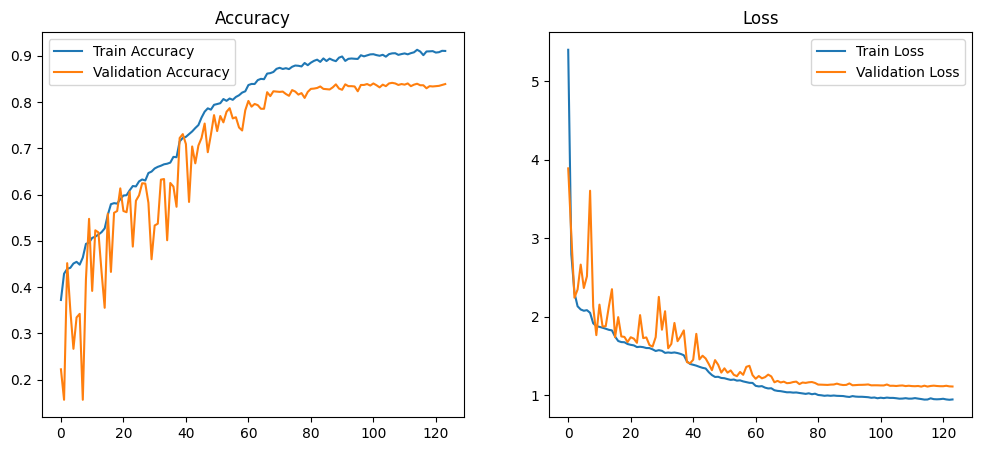

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       143
           1       0.88      0.89      0.88       149
           2       0.94      0.87      0.90        92
           3       0.88      0.90      0.89       135
           4       0.87      0.85      0.86       150
           5       0.89      0.98      0.93        95
           6       0.71      0.80      0.75       116
           7       0.84      0.89      0.87       150
           8       0.77      0.72      0.74       131
           9       0.72      0.72      0.72       150
          10       0.91      0.89      0.90       106
          11       0.82      0.81      0.82       117

    accuracy                           0.84      1534
   macro avg       0.84      0.84      0.84      1534
weighted avg       0.84      0.84      0.84      1534



In [20]:
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Visualize Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Evaluate Model Performance with Classification Report
y_pred = model.predict(validation_dataset_final)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from the validation dataset
y_true = []
for images, labels in validation_dataset_final:
  y_true.extend(np.argmax(labels.numpy(), axis=1))

# Convert y_true to a NumPy array
y_true = np.array(y_true)

print(classification_report(y_true, y_pred_classes))

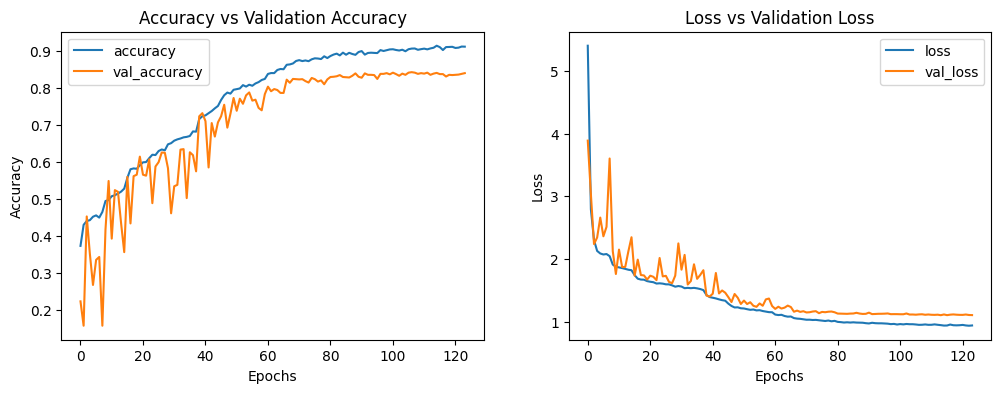

In [21]:
import matplotlib.pyplot as plt

# Get history data
history_dict = history.history

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='accuracy')
plt.plot(history_dict['val_accuracy'], label = 'val_accuracy')
plt.title('Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='loss')
plt.plot(history_dict['val_loss'], label = 'val_loss')
plt.title('Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [22]:
model.save('model_beta.keras')

In [23]:
import tensorflow as tf
import os

# Get the current working directory
curr_dir = os.getcwd()

# Define the model path relative to the current working directory
model_path = os.path.join(curr_dir, 'model_beta.keras')

# Load the model
model = tf.keras.models.load_model(model_path)

# Konversi ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite
with open("model.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmppykdezz2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  132101323303824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132101323305408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132101323887488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132101323885904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132101323647536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132101522943040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132101323890128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132101323894704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132101322052480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132101322050720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132101322050

Saving plastik3.jpg to plastik3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


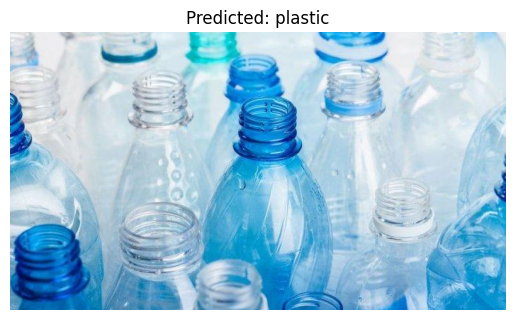

Predicted class index: 8
Predicted label: plastic


In [29]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Upload file
uploaded = files.upload()

# Ambil nama file pertama yang diupload
image_path = list(uploaded.keys())[0]

# Load dan preprocess gambar
img = image.load_img(image_path, target_size=(150,150))  # Sesuaikan ukuran input model
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
img_array = img_array / 255.0  # Normalisasi jika diperlukan

# Prediksi
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

# (Opsional) Konversi indeks ke label nama
class_indices = train_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}
predicted_label = class_labels[predicted_class]

# Tampilkan gambar yang diupload
plt.imshow(image.load_img(image_path))
plt.axis('off')
plt.title(f"Predicted: {predicted_label}")
plt.show()

print(f"Predicted class index: {predicted_class}")
print(f"Predicted label: {predicted_label}")


In [ ]:
for c in classes:
  list_file = os.listdir(curr_directory + '/garbage-dataset/garbage_classification/' + c)
  print(c + ' : ' + str(len(list_file)))

In [ ]:
import shutil

for c in classes:
  list_file = os.listdir(curr_directory + '/garbage-dataset/garbage_classification/' + c)

  for d in data:
    directory = os.listdir(curr_directory + '/garbage-dataset/garbage_classification/' + d + '/' + c)
    print(d + ' in ' + c + ' : ' + str(len(directory)))
  print('\n')

In [ ]:
label = os.listdir(curr_directory + '/garbage-dataset/garbage_classification')

print(label)